## Write Survey Polygons in Shapefile from Segy Headers (Fiona, Shapely)

This notebook demonstrates how to read header information from segy and las files, <br>
and write shapefiles for seismic survey areas and well locations.

Data: F3 Block in The Netherlands <br>
URL: https://terranubis.com/datainfo/Netherlands-Offshore-F3-Block-Complete

### Import libraries

In [1]:
# Standard libraries
import glob                                                     # File path
import numpy as np                                              # Scientific Computing
import matplotlib.pyplot as plt                                 # Plotting

# Libraries for GIS data
import geopandas as gpd                                         # Read and display GIS Data
import fiona                                                    # GIS Data I/O Library
from shapely.geometry import mapping, LineString, Point         # Geometry Library

# Libraries for subsurface data
import lasio                                                    # Las I/O Library
from obspy.io.segy.segy import _read_segy                       # Segy I/O library

### Function to save shapefiles

In [2]:
def save_shapefile(obj_shapely,path,filename):
    schema = {                                                       # Define properties 
        'geometry': obj_shapely.type,
        'properties': {'id': 'int','Path': 'str'},
    }

    with fiona.open(filename, 'w', 'ESRI Shapefile', schema) as c:   # Open/Close shapefile
        c.write({                                                    # Write shapefile
            'geometry': mapping(obj_shapely),
            'properties': {'id': 123, 'Path':path},
        })

### Read segy file and write survey area as polygons in shapefile format

In [3]:
path_seis = './data/seismic/F3_seismic.sgy'
filename = './shapefile/F3_seismic.shp'

file_segy = _read_segy(path_seis).traces                                  # Read segy files
scaler = abs(file_segy[0].header.scalar_to_be_applied_to_all_coordinates) # Scaler for coordinate
x = np.stack([t.header.source_coordinate_x/scaler for t in file_segy])    # X coordinate
y = np.stack([t.header.source_coordinate_y/scaler for t in file_segy])    # Y coordinate

polygon = LineString(list(zip(x,y)))                                      # Create polygon
save_shapefile(polygon,path_seis,filename)                                # Save in shapefile

### Read las files and write well locations as points in shapefile format

In [4]:
def is_num(s):
    ''' Function to check if a str variable contains float. '''
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True

In [5]:
files = glob.glob('./data/las/*.las')
for path_las in files:
    # Well name and filepath for shapefile output
    wellname = path_las.split('\\')[1].split('_')[0]
    filename = './shapefile/' + wellname + '.shp'
    
    # Read las data
    log = lasio.read(path_las)
    
    # Get coordinates from header
    for item in log.well:
        if item.mnemonic == 'LOC':
            x,y = [float(s) for s in item.value.split() if is_num(s)]

    # Create a point object
    point = Point(x,y)
    
    # Save it in shapefile format
    save_shapefile(point,path_las,filename)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


### Read and display shapefiles

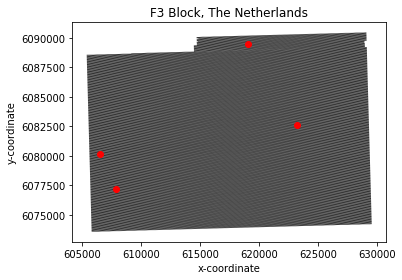

In [6]:
fig, ax = plt.subplots()

# Seismic survey
p0 = gpd.read_file('./shapefile/F3_seismic.shp')
p0.plot(ax=ax, color='black', lw=0.1, zorder=1)

# Well locations
p1 = gpd.read_file('./shapefile/F02-1.shp')
p1.plot(ax=ax, facecolor='red', zorder=2)
p2 = gpd.read_file('./shapefile/F03-2.shp')
p2.plot(ax=ax, facecolor='red', zorder=2)
p3 = gpd.read_file('./shapefile/F03-4.shp')
p3.plot(ax=ax, facecolor='red', zorder=2)
p4 = gpd.read_file('./shapefile/F06-1.shp')
p4.plot(ax=ax, facecolor='red', zorder=2)

plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('F3 Block, The Netherlands')
plt.tight_layout()